In [1]:
import json, csv, pandas as pd, numpy as np, parse_xml
import matplotlib.pyplot as plt
from lxml import etree
import xml.etree.ElementTree as ET
from multiprocessing import Pool, cpu_count
from multiprocessing import Process

#### Functions for extracting data from the DrugBank xml file

In [ ]:
# Modified By Thai Tran and provided by Ping lab, modofied by me (Dylan Steinecke) https://github.com/CaseOLAP/covid-cvd-knowledgegraph/blob/main/01_DrugBankXML_CVDrugs_Extraction/parse_xml.py

class ParseXML():
    '''
    This is the class for parsing the DrugBank XML file to extract relevant information (ID, name, entities, etc.) for cardiovascular drugs. 
    '''
    def getID(ele):
        '''
        @param ele is the element in XML root
        @return ID is the DrugBank accession number/ID of the element (drug)
        '''
        try:
            ID = ele.find("{http://www.drugbank.ca}drugbank-id").text
        except:
            ID = "Null"
        return ID

    def getName(ele):
        '''
        @param ele is the element in XML root
        @return name is the name of the element (drug)
        '''
        try:
            name = ele.find("{http://www.drugbank.ca}name").text
        except:
            name = "Null"
        return name

    def getEntities(ele, entity_type):
        
        '''
        @param ele is the element in XML root
        @param entity_type is one of the following: 'carriers', 'targets', 'transporters' , 'enzymes'
        @return allEntities is the list of all entities (carriers, targets, transporters, or enzymes) for the element (drug). 
        Each element in the list contains the name, DrugBank accession number/ID, list of actions, and UniProt ID of the element. 
        '''

        allEntities =  []
        try:
            entity = ele.find('{http://www.drugbank.ca}' + entity_type).\
                            findall('{http://www.drugbank.ca}' +\
                            entity_type[:len(entity_type)-1])
            for child in entity:
                if child.find('{http://www.drugbank.ca}organism').text=='Humans':
                    entity_dict = {}
                    #find entity name-------------------------
                    try:
                        e_name = child.find('{http://www.drugbank.ca}name').text
                    except:
                        e_name = "Null"

                    # find actions------------------------------------    
                    try:
                        e_actions = []
                        for term in list(child.find('{http://www.drugbank.ca}actions')):
                            e_actions.append(term.text)
                    except:
                        e_actions = "Null"

                    # find entity drugbank ids------------------------------
                    try:
                        e_id = child.find('{http://www.drugbank.ca}id').text
                    except:
                        e_name = "Null"

                    # find entity Uniprot ids------------------------------    
                    try:
                        e_uid = child.find('{http://www.drugbank.ca}polypeptide').\
                                        get('id')
                    except:
                        e_uid = "Null"

                    entity_dict.update({"name": e_name,\
                                    "drugbank_id": e_id,\
                                    "actions" : e_actions,\
                                    "uniprot_id" : e_uid}) 
                    allEntities.append(entity_dict)
        except:
            allEntities = []
                
        return allEntities

#### Download

In [ ]:
''' You need an authorized DrugBank account for this '''
# ! curl -Lfv -o input/drugbank_all_full_database.xml.zip -u USERNAME:PASSWORD https://go.drugbank.com/releases/5-1-9/downloads/all-full-database
#! unzip input/drugbank_all_full_database.xml.zip
#! mv 'full database.xml' full_drugbank.xml

#### Parse

In [6]:
path_where_drugbank_xml_is = 'full_drugbank.xml'
tree = ET.parse(path_where_drugbank_xml_is)
root = tree.getroot()

#### Get summary stats

In [118]:
all_drugs = set()
drug2targets, drug2carriers, drug2transporters, drug2enzyme= dict(), dict(), dict(), dict()
drug_target_rels, drug_carrier_rels, drug_transporter_rels, drug_enzyme_rels = 0, 0, 0, 0    
drug_carriers, drug_targets, drug_transporters, drug_enzymes = set(), set(), set(), set()
drugs_with_targets, drugs_with_carriers, drugs_with_transporters, drugs_with_enzymes = set(), set(), set(), set()

# Drugs
for count, ele in enumerate(root):
    drug_id = ParseXML.getID(ele)
    all_drugs.add(drug_id)
    
    # Relationships
    for relation in ['carriers', 'targets', 'transporters' , 'enzymes']:
        
        # Proteins
        proteins = ParseXML.getEntities(ele, relation)
        for protein in proteins:
            protein_id = protein['uniprot_id']
            if(protein_id != 'Null'):

                # Drug-Protein
                if(relation == 'targets'):
                    drug2targets.setdefault(drug_id,[]).append(protein_id)
                    drug_target_rels += 1
                    drug_targets.add(protein_id)
                    drugs_with_targets.add(drug_id)
                elif(relation == 'carriers'):
                    drug2carriers.setdefault(drug_id,[]).append(protein_id)
                    drug_carrier_rels += 1
                    drug_carriers.add(protein_id)
                    drugs_with_carriers.add(drug_id)

                elif(relation == 'transporters'):
                    drug2transporters.setdefault(drug_id,[]).append(protein_id)
                    drug_transporter_rels += 1
                    drug_transporters.add(protein_id)
                    drugs_with_transporters.add(drug_id)
                elif(relation == 'enzymes'):
                    drug2enzyme.setdefault(drug_id,[]).append(protein_id)
                    drug_enzyme_rels += 1
                    drug_enzymes.add(protein_id)   
                    drugs_with_enzymes.add(drug_id)
                    
print(len(all_drugs), 'total drugs')
print('')
print(len(drugs_with_targets), 'Drugs with Targets')
print(len(drugs_with_carriers), 'Drugs with Carriers')
print(len(drugs_with_transporters), 'Drugs with Transporters')
print(len(drugs_with_enzymes), 'Drugs with Enzymes')
print('')
print(len(drug_targets), 'Targets')
print(len(drug_carriers), 'Carriers')
print(len(drug_transporters), 'Transporter')
print(len(drug_enzymes), 'Enzymes')
print('')
print(drug_target_rels, 'Drug-Target Relationships')
print(drug_carrier_rels, 'Drug-Carrier Relationships')
print(drug_transporter_rels, 'Drug-Transporter Relationships')
print(drug_enzyme_rels, 'Drug-Enzyme Relationships')

14594 total drugs

5804 Drugs with Targets
612 Drugs with Carriers
1050 Drugs with Transporters
1737 Drugs with Enzymes

2801 Targets
75 Carriers
258 Transporter
393 Enzymes

14421 Drug-Target Relationships
866 Drug-Carrier Relationships
3214 Drug-Transporter Relationships
5360 Drug-Enzyme Relationships


Top 5 [298, 145, 144, 124, 124]


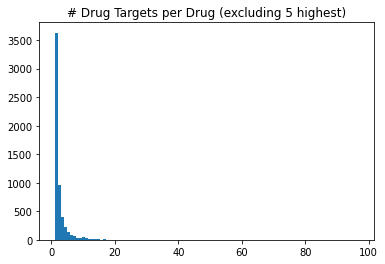

In [120]:
num_targets = sorted([len(targets) for targets in drug2targets.values()])
plt.title('# Drug Targets per Drug (excluding 5 highest)')
plt.hist(num_targets[:-5], bins = 100);
print('Top 5', sorted(num_targets, reverse = True)[:5])

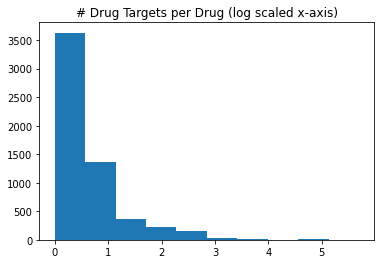

In [107]:
plt.title('# Drug Targets per Drug (log scaled x-axis)')
plt.hist([np.log(num_targ) for num_targ in num_targets]);

In [72]:
print(min(num_targets), 'minimum #targets')
print(max(num_targets), 'maximum #targets')
print(round(np.mean(num_targets), 3), 'average #targets')
print(np.median(num_targets), 'median #targets')

1 minimum #targets
298 maximum #targets
2.485 average #targets
1.0 median #targets


In [121]:
drugwithtarget = 0
num_actions, numproteins = 0, 0 
uniq_acts, uniqprotein, unique_drug = dict(), set(), set()  
for ele in root:
    ID = ParseXML.getID(ele)
    proteins = ParseXML.getEntities(ele, 'targets')

    if len(proteins) > 0:
        drugwithtarget += 1
        has_action = False
        for protein in proteins:
            protein_id = protein['uniprot_id']
            actions = protein['actions']
            uniqprotein.add(protein_id)
             
            if(protein_id != 'Null'):
                if len(actions) > 0:
                    has_action = True
                    for action in actions:

                        # DrugBank Drug
                        uniq_acts.setdefault(action,0)
                        num_actions += 1
                        uniq_acts[action] += 1                                

        if has_action == True:
            unique_drug.add(ID)
numproteins = len(uniqprotein)
num_drugs = len(unique_drug)

print('Total Drug-action-Target Relationships:',num_drugs, num_actions, numproteins)
print('Unique Actions:',len(uniq_acts), '\nUnique Proteins:',len(uniqprotein), '\nUnique Drugs:',len(unique_drug))

print('Actions:')
sorted_uniq_acts = dict(sorted(uniq_acts.items(), key=lambda x:x[1], reverse=True))
sorted_uniq_acts

Total Drug-action-Target Relationships: 2261 7498 2802
Unique Actions: 47 
Unique Proteins: 2802 
Unique Drugs: 2261
Actions:


{'inhibitor': 2422,
 'antagonist': 1693,
 'agonist': 1240,
 'binder': 377,
 'ligand': 335,
 'cofactor': 193,
 'activator': 176,
 'potentiator': 146,
 'inducer': 118,
 'partial agonist': 94,
 'substrate': 84,
 'antibody': 82,
 'modulator': 74,
 'positive allosteric modulator': 69,
 'other/unknown': 63,
 'product of': 41,
 'blocker': 35,
 'negative modulator': 33,
 'other': 31,
 'inverse agonist': 27,
 'stimulator': 21,
 'unknown': 18,
 'chaperone': 17,
 'downregulator': 16,
 'regulator': 14,
 'allosteric modulator': 11,
 'stabilization': 9,
 'binding': 9,
 'multitarget': 7,
 'inactivator': 6,
 'cleavage': 5,
 'antisense oligonucleotide': 4,
 'chelator': 4,
 'component of': 4,
 'suppressor': 3,
 'neutralizer': 3,
 'oxidizer': 3,
 'inhibitory allosteric modulator': 2,
 'partial antagonist': 1,
 'degradation': 1,
 'incorporation into and destabilization': 1,
 'weak inhibitor': 1,
 'nucleotide exchange blocker': 1,
 'inhibition of synthesis': 1,
 'translocation inhibitor': 1,
 'gene replace